# Neural Networks and Deep Learning (ECS659P/ECS7026P)


# 230413612 - Kabilan Mani - Advanced Model

## Importing Libraries and Modules

In this section, we import necessary libraries and modules, including PyTorch for deep learning functionalities, torchvision for handling datasets, and matplotlib for visualization. We also set up data preprocessing and loading routines using torchvision transforms and DataLoader.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau


## Data Loading and Data Agumentation

In [ ]:
# Define the dataset and data loaders with data augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

## Model

Here, we define the architecture of our ResNet model. We have separate classes for ResNet blocks, intermediate blocks, and output blocks. These classes encapsulate the layers and operations needed to construct the ResNet model with customizable parameters like block size and number of convolutional layers.

### Define ResNet Block

In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.downsample(identity)
        out = self.relu(out)
        return out

### Define Intermediate Block

In [ ]:
# Define the IntermediateBlock
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers, kernel_size=3, activation=nn.ReLU()):
        super(IntermediateBlock, self).__init__()
        self.conv_layers = nn.ModuleList([])
        for _ in range(num_layers):
            self.conv_layers.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2),
                nn.BatchNorm2d(out_channels),
                activation
            ))
        self.fc = nn.Linear(in_channels, num_layers)

    def forward(self, x):
        m = x.mean([2, 3])  # Compute mean separately for each color channel
        a = torch.softmax(self.fc(m), dim=1)  # Calculate 'a' using a fully connected layer
        x_prime = sum(a[:, i].view(-1, 1, 1, 1) * conv(x) for i, conv in enumerate(self.conv_layers))
        return x_prime

### Define Output Block

In [ ]:
# Define the OutputBlock
class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes, num_fc_layers=1, activation=nn.ReLU()):
        super(OutputBlock, self).__init__()
        self.fc_layers = nn.ModuleList([nn.Linear(in_channels, in_channels) for _ in range(num_fc_layers - 1)])
        self.fc_layers.append(nn.Linear(in_channels, num_classes))  # Final layer to num_classes
        self.activation = activation

    def forward(self, x):
        m = x.mean([2, 3])  # Compute mean separately for each color channel
        for fc in self.fc_layers[:-1]:
            m = self.activation(fc(m))
        o = self.fc_layers[-1](m)
        return o

### Define Model

In [ ]:
# Define the IntermediateBlock
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers, kernel_size=3, activation=nn.ReLU()):
        super(IntermediateBlock, self).__init__()
        self.conv_layers = nn.ModuleList([])
        for _ in range(num_layers):
            self.conv_layers.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2),
                nn.BatchNorm2d(out_channels),
                activation
            ))
        self.fc = nn.Linear(in_channels, num_layers)

    def forward(self, x):
        m = x.mean([2, 3])  # Compute mean separately for each color channel
        a = torch.softmax(self.fc(m), dim=1)  # Calculate 'a' using a fully connected layer
        x_prime = sum(a[:, i].view(-1, 1, 1, 1) * conv(x) for i, conv in enumerate(self.conv_layers))
        return x_prime

In [ ]:
# Define the OutputBlock
class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes, num_fc_layers=1, activation=nn.ReLU()):
        super(OutputBlock, self).__init__()
        self.fc_layers = nn.ModuleList([nn.Linear(in_channels, in_channels) for _ in range(num_fc_layers - 1)])
        self.fc_layers.append(nn.Linear(in_channels, num_classes))  # Final layer to num_classes
        self.activation = activation

    def forward(self, x):
        m = x.mean([2, 3])  # Compute mean separately for each color channel
        for fc in self.fc_layers[:-1]:
            m = self.activation(fc(m))
        o = self.fc_layers[-1](m)
        return o

In [ ]:
# Define the ResNet model
class ResNet(nn.Module):
    def __init__(self, input_channels, output_shape, num_blocks, num_conv_layers, block=IntermediateBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, num_conv_layers)
        self.layer2 = self._make_layer(block, 128, num_conv_layers, stride=2)
        self.layer3 = self._make_layer(block, 256, num_conv_layers, stride=2)
        self.layer4 = self._make_layer(block, 512, num_conv_layers, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.output_block = OutputBlock(512, output_shape)

    def _make_layer(self, block, out_channels, num_conv_layers, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, num_conv_layers))
        self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = self.output_block(out)
        return out

## Loss Function, Optimizer, and Scheduler

We set up the necessary components for training the ResNet model. This includes defining the loss function (Cross Entropy Loss), optimizer (Stochastic Gradient Descent with momentum), and a learning rate scheduler (ReduceLROnPlateau) for dynamically adjusting the learning rate during training based on validation loss.

In [ ]:
# Define the loss function, optimizer, and scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet(input_channels=3, output_shape=10, num_blocks=4, num_conv_layers=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

## Helper Functions

We define helper functions like correct and evaluate_metric for calculating accuracy metrics during training and evaluation. Additionally, we have the train function responsible for executing the training loop, performing gradient updates, and evaluating the model's performance.

In [ ]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1)
    return (y_hat == y).float().sum()

def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = 0.
    n = 0
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        c += metric(logits, y)
        n += len(y)
    return float(c / n)

## Training, Testing and Plotting the Accuracy and Loss

1. This section contains the main training loop where we iterate over epochs, batches, and perform forward and backward passes through the network. It includes gradient clipping to prevent exploding gradients and early stopping to halt training if the validation loss doesn't improve for a specified number of epochs.

2. Finally, we execute the training process by calling the train function with specified hyperparameters like the number of epochs, early stopping criteria, and clipping value. We print out the best testing accuracy achieved by the model during training.

Files already downloaded and verified
Files already downloaded and verified

Epoch 1/50.


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[1,   100] loss: 1.990
[1,   200] loss: 1.735
[1,   300] loss: 1.662
[1,   400] loss: 1.571
[1,   500] loss: 1.503
[1,   600] loss: 1.466
[1,   700] loss: 1.376
Training accuracy: 0.5069199800491333. Testing accuracy: 0.5220000147819519. Duration: 99.568s.

Epoch 2/50.
[2,   100] loss: 1.318
[2,   200] loss: 1.263
[2,   300] loss: 1.273
[2,   400] loss: 1.214
[2,   500] loss: 1.195
[2,   600] loss: 1.167
[2,   700] loss: 1.161
Training accuracy: 0.5931800007820129. Testing accuracy: 0.6024999618530273. Duration: 99.622s.

Epoch 3/50.
[3,   100] loss: 1.098
[3,   200] loss: 1.082
[3,   300] loss: 1.071
[3,   400] loss: 1.063
[3,   500] loss: 1.040
[3,   600] loss: 1.021
[3,   700] loss: 1.008
Training accuracy: 0.6321399807929993. Testing accuracy: 0.6373999714851379. Duration: 99.574s.

Epoch 4/50.
[4,   100] loss: 0.988
[4,   200] loss: 0.960
[4,   300] loss: 0.973
[4,   400] loss: 0.959
[4,   500] loss: 0.939
[4,   600] loss: 0.918
[4,   700] loss: 0.915
Training accuracy: 0.68158000

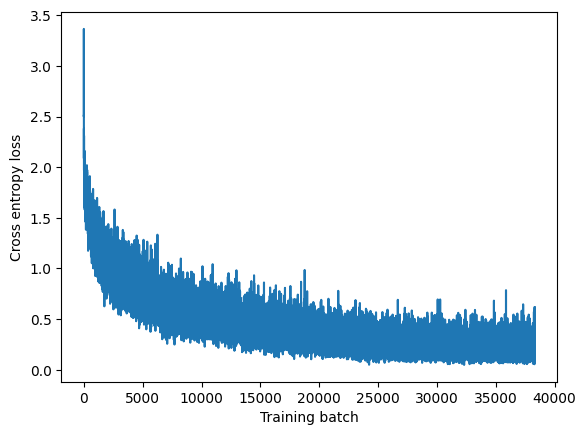

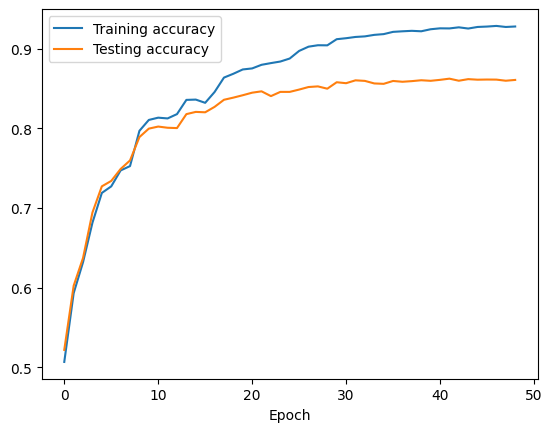

Best testing accuracy: 0.8622999787330627


In [ ]:
# Implement the training loop with early stopping
def train(model, trainloader, criterion, optimizer, scheduler, num_epochs=50, early_stop=7):
    losses = []
    train_accs = []
    test_accs = []
    best_test_acc = 0.0
    patience = 0

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch + 1}/{num_epochs}.')
        start_time = time.perf_counter()
        model.train()

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            losses.append(float(loss))

            if i % 100 == 99:
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0

        with torch.no_grad():
            model.eval()
            train_acc = evaluate_metric(model, trainloader, correct)
            test_acc = evaluate_metric(model, testloader, correct)
            train_accs.append(train_acc)
            test_accs.append(test_acc)

            scheduler.step(loss)  # Update the learning rate

            if test_acc > best_test_acc:
                best_test_acc = test_acc
                patience = 0
            else:
                patience += 1

            if patience >= early_stop:
                print(f'Early stopping after {epoch + 1} epochs.')
                break

        end_time = time.perf_counter()
        print(f'Training accuracy: {train_acc}. Testing accuracy: {test_acc}. Duration: {end_time - start_time:.3f}s.')

    # Plot the loss for each training batch
    plt.figure()
    plt.plot(losses)
    plt.xlabel('Training batch')
    plt.ylabel('Cross entropy loss')
    plt.show()

    # Plot the training and testing accuracy for each epoch
    plt.figure()
    plt.plot(train_accs, label='Training accuracy')
    plt.plot(test_accs, label='Testing accuracy')
    plt.legend(loc='best')
    plt.xlabel('Epoch')
    plt.show()

    return best_test_acc

# Train the model
num_epochs = 50
early_stop = 7
best_test_acc = train(model, trainloader, criterion, optimizer, scheduler, num_epochs, early_stop)
print(f'Best testing accuracy: {best_test_acc}')